# Import Libraries

In [ ]:
# For drive access
from google.colab import drive
drive.mount('/content/drive')

# Standard libraries
import numpy as np
import pandas as pd

# for loading the pickle files with features and labels
import pickle

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


# Load features and labels from train and val pickle

In [ ]:
with open('/content/drive/MyDrive/project/train_val_features_pkl/train_val_8_sec_audio_features_avgpooled.pkl', 'rb') as file:
  audio_df = pickle.load(file)

In [ ]:
audio_df

{'train': {'mfcc': array([[0.54529715, 0.4793393 , 0.5349132 , ..., 0.4413777 , 0.48703906,
          0.4391229 ],
         [0.5793472 , 0.4298672 , 0.53157544, ..., 0.44011986, 0.4861899 ,
          0.45821744],
         [0.58690274, 0.4212866 , 0.5418751 , ..., 0.44207054, 0.48264065,
          0.45636433],
         ...,
         [0.64385235, 0.6829456 , 0.53566563, ..., 0.5652174 , 0.54604053,
          0.5220579 ],
         [0.63340336, 0.6876703 , 0.5409084 , ..., 0.54519475, 0.53867674,
          0.49238336],
         [0.62090445, 0.68252176, 0.5312934 , ..., 0.5375894 , 0.5312795 ,
          0.48669696]], dtype=float32),
  'chroma': array([[0.33323073, 0.30428657, 0.2593368 , ..., 0.5534823 , 0.5671482 ,
          0.39478505],
         [0.3348951 , 0.2847971 , 0.28591642, ..., 0.48760402, 0.5730938 ,
          0.4367055 ],
         [0.30589613, 0.32092458, 0.35909373, ..., 0.51112914, 0.47443873,
          0.3541228 ],
         ...,
         [0.63341504, 0.69855356, 0.7788    , 

In [ ]:
with open('/content/drive/MyDrive/project/train_val_features_pkl/train_val_8_sec_non_audio_features.pkl', 'rb') as file:
  non_audio_df = pickle.load(file)

In [ ]:
non_audio_df

{'train': {'type': array(['blank', 'blank', 'blank', ..., 'blank', 'blank', 'blank'],
        dtype='<U5'),
  'continent': array(['AFRICA', 'AFRICA', 'AFRICA', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([5., 5., 5., ..., 5., 5., 5.]),
  'label': array([0, 0, 0, ..., 2, 2, 2])},
 'val': {'type': array(['song', 'call', 'call', ..., 'blank', 'call', 'call'], dtype='<U5'),
  'continent': array(['EUROPE', 'EUROPE', 'EUROPE', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([3.5, 5. , 4. , ..., 5. , 3. , 3. ]),
  'label': array([0, 0, 1, ..., 2, 1, 2])}}

## confirm the audio features and non_audio features labels line-up

In [ ]:
assert np.array_equal(audio_df['train']['label'], non_audio_df['train']['label'])

In [ ]:
assert np.array_equal(audio_df['val']['label'], non_audio_df['val']['label'])

# Shuffle the data

In [ ]:
def shuffle_data(audio_features, non_audio_features):
  input_len = len(audio_features['label'])
  input_indices = np.random.permutation(input_len)
  audio_features = {key: np.array([audio_features[key][i] for i in input_indices]) for key in audio_features}
  non_audio_features = {key: np.array([non_audio_features[key][i] for i in input_indices]) for key in non_audio_features}

  return audio_features, non_audio_features

In [ ]:
audio_df['train'], non_audio_df['train'] = shuffle_data(audio_df['train'], non_audio_df['train'])

In [ ]:
for key in audio_df['train'].keys():
  display(key)
  display(audio_df['train'][key].shape)
  display(audio_df['train'][key][:5])

'mfcc'

(4763, 20)

array([[0.579351  , 0.6438036 , 0.668339  , 0.56331927, 0.7007058 ,
        0.56325966, 0.6335729 , 0.46764037, 0.57766515, 0.57501316,
        0.53246045, 0.52669257, 0.49751362, 0.5534108 , 0.53549707,
        0.4972523 , 0.5051326 , 0.5173944 , 0.5583625 , 0.4865446 ],
       [0.5791355 , 0.5856383 , 0.54721946, 0.5763345 , 0.5057687 ,
        0.5371092 , 0.5310731 , 0.502836  , 0.559161  , 0.52384067,
        0.5166073 , 0.5416599 , 0.50949866, 0.5363237 , 0.501673  ,
        0.5055509 , 0.5198671 , 0.5482329 , 0.48708957, 0.52608013],
       [0.5286411 , 0.5799211 , 0.5862537 , 0.50855017, 0.5448757 ,
        0.30845624, 0.46963498, 0.28670865, 0.38689232, 0.33491588,
        0.35520726, 0.35553744, 0.29808357, 0.33512098, 0.27679452,
        0.28968474, 0.32249567, 0.36979863, 0.3953115 , 0.33582178],
       [0.54600185, 0.5324451 , 0.32555106, 0.42977634, 0.4879379 ,
        0.28058612, 0.37862107, 0.36121663, 0.505882  , 0.38599288,
        0.41977683, 0.4883107 , 0.42771322, 0

'chroma'

(4763, 12)

array([[0.39739537, 0.50743604, 0.69718534, 0.64672315, 0.6742777 ,
        0.74856025, 0.76878   , 0.6884679 , 0.57683223, 0.58799297,
        0.55827814, 0.41925797],
       [0.4150034 , 0.44399425, 0.48608676, 0.49194032, 0.40593803,
        0.3962545 , 0.48535663, 0.5205814 , 0.44743624, 0.510769  ,
        0.49330616, 0.40106645],
       [0.6168788 , 0.59541184, 0.8296709 , 0.62740755, 0.4997449 ,
        0.5595455 , 0.5287512 , 0.52669644, 0.5262273 , 0.57922095,
        0.62211674, 0.74784887],
       [0.28326067, 0.15479493, 0.14445938, 0.10779578, 0.16120441,
        0.2263042 , 0.24995244, 0.96766233, 0.31024054, 0.29989797,
        0.16186407, 0.25966698],
       [0.7606128 , 0.75886893, 0.69292545, 0.64430964, 0.6202984 ,
        0.6140454 , 0.6356093 , 0.6988729 , 0.7370601 , 0.7811701 ,
        0.78142315, 0.7788779 ]], dtype=float32)

'rms'

(4763, 1)

array([[0.01166727],
       [0.01975782],
       [0.00355201],
       [0.01011833],
       [0.04402697]], dtype=float32)

'spectral_centroid'

(4763, 1)

array([[0.3362751 ],
       [0.44319284],
       [0.44192895],
       [0.3922283 ],
       [0.22388758]], dtype=float32)

'melspectrogram'

(4763, 20)

array([[0.70001864, 0.62854785, 0.57757473, 0.5520883 , 0.53861696,
        0.5343446 , 0.53020185, 0.5412595 , 0.56602204, 0.54710406,
        0.5026073 , 0.47967157, 0.45728475, 0.45480695, 0.4406744 ,
        0.43313837, 0.43532082, 0.43560854, 0.45031485, 0.44755444],
       [0.5808495 , 0.5376825 , 0.53441304, 0.5454092 , 0.55484957,
        0.555468  , 0.5486393 , 0.54895645, 0.5490161 , 0.5554186 ,
        0.54400027, 0.52912575, 0.5180022 , 0.51905906, 0.5245219 ,
        0.5230602 , 0.51356167, 0.47379923, 0.43080005, 0.39614967],
       [0.58485097, 0.5980399 , 0.5505872 , 0.53811425, 0.51133835,
        0.49074695, 0.48995128, 0.48704654, 0.49537742, 0.49226445,
        0.47750208, 0.47994494, 0.46392524, 0.45224935, 0.4326276 ,
        0.42187867, 0.41199592, 0.39987543, 0.41237068, 0.4197036 ],
       [0.40222612, 0.44703645, 0.47818217, 0.54797256, 0.5478947 ,
        0.5500372 , 0.5752148 , 0.57889944, 0.62917054, 0.6980391 ,
        0.63617676, 0.6267436 , 0.5322726 , 0

'label'

(4763,)

array([2, 2, 1, 2, 1])

In [ ]:
for key in non_audio_df['train'].keys():
  display(key)
  display(non_audio_df['train'][key].shape)
  display(non_audio_df['train'][key][:5])

'type'

(4763,)

array(['call', 'song', 'call', 'call', 'call'], dtype='<U5')

'continent'

(4763,)

array(['EUROPE', 'EUROPE', 'EUROPE', 'ASIA', 'EUROPE'], dtype='<U8')

'rating'

(4763,)

array([4. , 3.5, 3. , 3. , 4. ])

'label'

(4763,)

array([2, 2, 1, 2, 1])

In [ ]:
audio_df['val'], non_audio_df['val'] = shuffle_data(audio_df['val'], non_audio_df['val'])

In [ ]:
for key in audio_df['val'].keys():
  display(key)
  display(audio_df['val'][key].shape)
  display(audio_df['val'][key][:5])

'mfcc'

(2430, 20)

array([[0.69124705, 0.37565866, 0.3079931 , 0.5275989 , 0.4383518 ,
        0.4689881 , 0.49329937, 0.5001705 , 0.47086647, 0.42331028,
        0.3053899 , 0.45392925, 0.4184839 , 0.3203666 , 0.3412653 ,
        0.54416835, 0.40640494, 0.4126268 , 0.6185635 , 0.3479116 ],
       [0.81909317, 0.7182319 , 0.47433323, 0.5383366 , 0.4503839 ,
        0.3189943 , 0.43616822, 0.34205064, 0.35925847, 0.4766805 ,
        0.42357633, 0.5464946 , 0.46817568, 0.5339801 , 0.4867738 ,
        0.55346704, 0.50651205, 0.5727945 , 0.5294831 , 0.5194657 ],
       [0.48991185, 0.42542234, 0.35691386, 0.25316802, 0.27795115,
        0.06242232, 0.24645571, 0.18036471, 0.34636337, 0.3480411 ,
        0.42299327, 0.44235882, 0.5167459 , 0.60558355, 0.60639954,
        0.56554896, 0.5524442 , 0.61106575, 0.5680846 , 0.48012352],
       [0.8229526 , 0.72731715, 0.5345375 , 0.50202835, 0.57177615,
        0.3675864 , 0.6119572 , 0.5922539 , 0.5563236 , 0.46053228,
        0.50497097, 0.50351995, 0.43535084, 0

'chroma'

(2430, 12)

array([[0.47883797, 0.27254748, 0.1936562 , 0.27939832, 0.34559366,
        0.4550423 , 0.54872775, 0.39113942, 0.24028732, 0.26953217,
        0.34740472, 0.52101815],
       [0.54798514, 0.4611798 , 0.45819983, 0.4608716 , 0.49084258,
        0.5287837 , 0.5602534 , 0.6643992 , 0.6804415 , 0.6747002 ,
        0.65100986, 0.6353231 ],
       [0.4924684 , 0.48824358, 0.5877358 , 0.52877134, 0.40923095,
        0.49827752, 0.5629368 , 0.60504174, 0.55733055, 0.5890628 ,
        0.592213  , 0.54930943],
       [0.687695  , 0.56117076, 0.49849048, 0.5035028 , 0.5322735 ,
        0.56964844, 0.52165425, 0.5580946 , 0.6607082 , 0.7198376 ,
        0.6880728 , 0.68747836],
       [0.46968034, 0.50057137, 0.6468313 , 0.7215803 , 0.57641286,
        0.47812238, 0.47135273, 0.47197407, 0.48973855, 0.47133029,
        0.4525581 , 0.4596497 ]], dtype=float32)

'rms'

(2430, 1)

array([[0.08393136],
       [0.09343126],
       [0.00395324],
       [0.0928347 ],
       [0.11139282]], dtype=float32)

'spectral_centroid'

(2430, 1)

array([[0.50203806],
       [0.22777331],
       [0.52084225],
       [0.22605254],
       [0.31795472]], dtype=float32)

'melspectrogram'

(2430, 20)

array([[0.4821549 , 0.4599733 , 0.4592268 , 0.49910098, 0.5842083 ,
        0.6194655 , 0.6680297 , 0.6756115 , 0.70410925, 0.7484516 ,
        0.7871906 , 0.7798607 , 0.7440997 , 0.7943748 , 0.7249628 ,
        0.7244541 , 0.69569486, 0.6541303 , 0.60372585, 0.5409836 ],
       [0.7247525 , 0.8383675 , 0.90028167, 0.88521075, 0.8563345 ,
        0.82816875, 0.8252912 , 0.8222062 , 0.81443983, 0.79410285,
        0.7740766 , 0.7690496 , 0.73728794, 0.7195663 , 0.6617792 ,
        0.60868984, 0.5812827 , 0.55429435, 0.54540545, 0.50944734],
       [0.2015381 , 0.4032547 , 0.52367824, 0.52131057, 0.5302013 ,
        0.5261373 , 0.5188434 , 0.502773  , 0.5333837 , 0.53100777,
        0.50079685, 0.4984342 , 0.47710824, 0.4659234 , 0.4500306 ,
        0.44553417, 0.47164106, 0.44384962, 0.4323271 , 0.4348303 ],
       [0.83398914, 0.8341992 , 0.7966947 , 0.8475173 , 0.8696048 ,
        0.8763891 , 0.8610201 , 0.81032306, 0.779528  , 0.7825926 ,
        0.7800997 , 0.7789922 , 0.7324288 , 0

'label'

(2430,)

array([0, 2, 1, 2, 1])

In [ ]:
for key in non_audio_df['val'].keys():
  display(key)
  display(non_audio_df['val'][key].shape)
  display(non_audio_df['val'][key][:5])

'type'

(2430,)

array(['both', 'call', 'call', 'call', 'call'], dtype='<U5')

'continent'

(2430,)

array(['EUROPE', 'EUROPE', 'EUROPE', 'EUROPE', 'EUROPE'], dtype='<U8')

'rating'

(2430,)

array([4.5, 4. , 5. , 3. , 4. ])

'label'

(2430,)

array([0, 2, 1, 2, 1])

# One Hot Encode Continents

In [ ]:
encoder = OneHotEncoder(sparse_output=False)

train_continents = non_audio_df['train']['continent'].reshape(-1, 1)
val_continents = non_audio_df['val']['continent'].reshape(-1, 1)

non_audio_df['train']['continent'] = encoder.fit_transform(train_continents)
non_audio_df['val']['continent'] = encoder.fit_transform(val_continents)

In [ ]:
display(non_audio_df['train']['continent'].shape)
display(non_audio_df['train']['continent'][:5])

display(non_audio_df['val']['continent'].shape)
display(non_audio_df['val']['continent'][:5])

(4763, 5)

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

(2430, 5)

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

# SVM Models

In [ ]:
train_results = {}
val_results = {}

In [ ]:
classes = ['barswa', 'comsan', 'eaywag1']

## With all features

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['chroma'], audio_df['train']['rms'], audio_df['train']['spectral_centroid'], audio_df['train']['melspectrogram'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.57935101, 0.6438036 , 0.66833901, ..., 0.        , 1.        ,
        0.        ],
       [0.57913548, 0.58563828, 0.54721946, ..., 0.        , 1.        ,
        0.        ],
       [0.5286411 , 0.57992113, 0.5862537 , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.5004214 , 0.51937073, 0.44722223, ..., 0.        , 1.        ,
        0.        ],
       [0.57142222, 0.66256487, 0.7120778 , ..., 0.        , 1.        ,
        0.        ],
       [0.46950918, 0.3285217 , 0.2136962 , ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
training_features.shape

(4763, 59)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['chroma'], audio_df['val']['rms'], audio_df['val']['spectral_centroid'], audio_df['val']['melspectrogram'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.69124705, 0.37565866, 0.30799311, ..., 0.        , 1.        ,
        0.        ],
       [0.81909317, 0.71823192, 0.47433323, ..., 0.        , 1.        ,
        0.        ],
       [0.48991185, 0.42542234, 0.35691386, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.50937366, 0.36574441, 0.67395914, ..., 0.        , 1.        ,
        0.        ],
       [0.45840833, 0.65378833, 0.59867388, ..., 0.        , 1.        ,
        0.        ],
       [0.48014399, 0.65538722, 0.5913316 , ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(2430, 59)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf')

clf = GridSearchCV(
        model,
        {"break_ties": [True, False], "C": [3,4,5]},
        verbose=1,
        n_jobs=2,
    )

clf.fit(training_features, audio_df['train']['label'])
display(clf.best_score_)
display(clf.best_params_)

model = SVC(kernel='rbf',
            break_ties=clf.best_params_['break_ties'],
            C=clf.best_params_['C'])

model.fit(training_features, audio_df['train']['label'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


0.9059407708518874

{'C': 5, 'break_ties': True}

SVC(C=5, break_ties=True)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['all_features'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['all_features'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.9328154524459374
Validation accuracy: 0.7444444444444445


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.96      0.91      0.93      1603
      comsan       0.96      0.94      0.95      1578
     eaywag1       0.89      0.95      0.92      1582

    accuracy                           0.93      4763
   macro avg       0.93      0.93      0.93      4763
weighted avg       0.93      0.93      0.93      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.88      0.69      0.77      1032
      comsan       0.67      0.77      0.72       618
     eaywag1       0.68      0.79      0.73       780

    accuracy                           0.74      2430
   macro avg       0.74      0.75      0.74      2430
weighted avg       0.76      0.74      0.75      2430



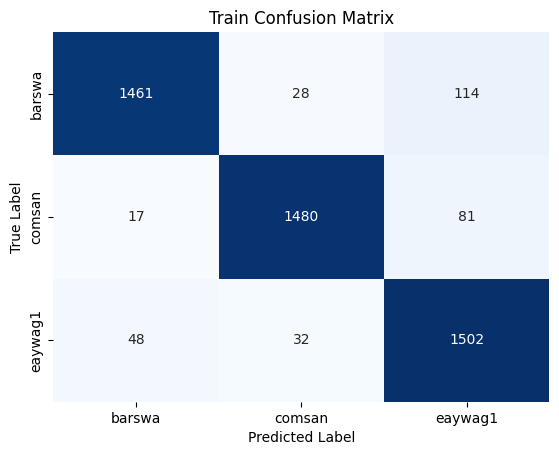

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

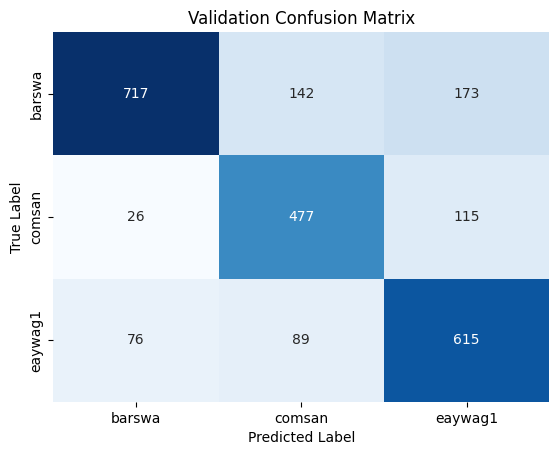

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & chroma & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['chroma'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.57935101, 0.6438036 , 0.66833901, ..., 0.        , 1.        ,
        0.        ],
       [0.57913548, 0.58563828, 0.54721946, ..., 0.        , 1.        ,
        0.        ],
       [0.5286411 , 0.57992113, 0.5862537 , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.5004214 , 0.51937073, 0.44722223, ..., 0.        , 1.        ,
        0.        ],
       [0.57142222, 0.66256487, 0.7120778 , ..., 0.        , 1.        ,
        0.        ],
       [0.46950918, 0.3285217 , 0.2136962 , ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
training_features.shape

(4763, 37)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['chroma'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.69124705, 0.37565866, 0.30799311, ..., 0.        , 1.        ,
        0.        ],
       [0.81909317, 0.71823192, 0.47433323, ..., 0.        , 1.        ,
        0.        ],
       [0.48991185, 0.42542234, 0.35691386, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.50937366, 0.36574441, 0.67395914, ..., 0.        , 1.        ,
        0.        ],
       [0.45840833, 0.65378833, 0.59867388, ..., 0.        , 1.        ,
        0.        ],
       [0.48014399, 0.65538722, 0.5913316 , ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(2430, 37)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf')

clf = GridSearchCV(
        model,
        {"break_ties": [True, False], "C": [3,4,5]},
        verbose=1,
        n_jobs=2,
    )

clf.fit(training_features, audio_df['train']['label'])
display(clf.best_score_)
display(clf.best_params_)

model = SVC(kernel='rbf',
            break_ties=clf.best_params_['break_ties'],
            C=clf.best_params_['C'])

model.fit(training_features, audio_df['train']['label'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


0.8763376599328083

{'C': 5, 'break_ties': False}

SVC(C=5)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc_chroma_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc_chroma_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.9059416334243124
Validation accuracy: 0.7325102880658436


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.92      0.90      0.91      1603
      comsan       0.95      0.91      0.93      1578
     eaywag1       0.86      0.91      0.88      1582

    accuracy                           0.91      4763
   macro avg       0.91      0.91      0.91      4763
weighted avg       0.91      0.91      0.91      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.82      0.71      0.76      1032
      comsan       0.65      0.71      0.68       618
     eaywag1       0.70      0.77      0.74       780

    accuracy                           0.73      2430
   macro avg       0.73      0.73      0.73      2430
weighted avg       0.74      0.73      0.73      2430



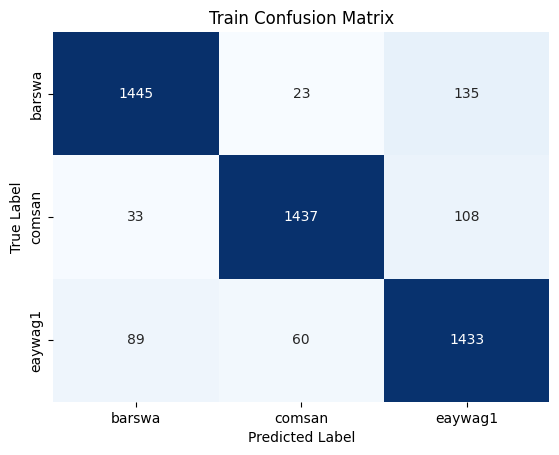

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

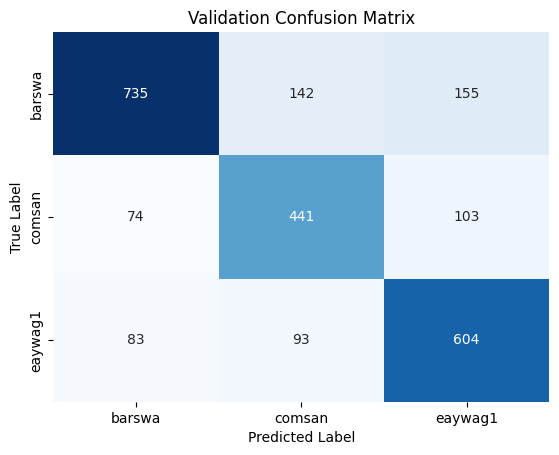

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

# Review results from all models

In [ ]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(2)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(2)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Val_Accuracy')
result_df

,Features,Train_Accuracy,Val_Accuracy
1,mfcc_chroma_continents,0.91,0.73
0,all_features,0.93,0.74
